In [1]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import nltk  # Fixed typo
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Step 1: Load dataset
df = pd.read_csv("/kaggle/input/starbucks-reviews-dataset/reviews_data.csv") 
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [3]:
df.columns

Index(['name', 'location', 'Date', 'Rating', 'Review', 'Image_Links'], dtype='object')

In [4]:
df.shape

(850, 6)

In [5]:
df.isnull().sum()

name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

In [6]:
# Step 2: Data Cleaning and Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    cleaned_text = ' '.join([word for word in tokens if word not in stop_words])
    return cleaned_text

# Fill missing values and clean text
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['text'] = df['Review'].apply(clean_text)
df.isnull().sum()

name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
text           0
dtype: int64

In [7]:
df["Rating"] = df["Rating"].astype(int)

In [8]:
df["Rating"].value_counts()

Rating
1    596
2     99
5     83
4     39
3     33
Name: count, dtype: int64

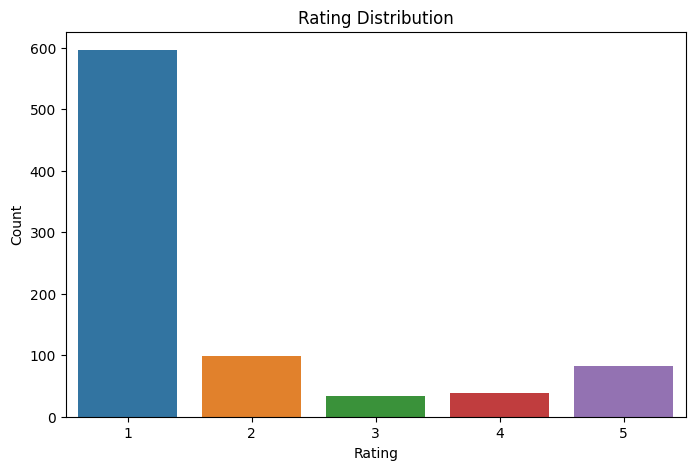

In [9]:
# Plot Rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [10]:
# Map sentiment labels
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'


df['label'] = df['Rating'].apply(map_sentiment)
df.drop(columns=["name", "location", "Date", "Image_Links", "Rating", "Review"], inplace=True)

In [11]:
# Check for missing values
missing_values = df.isnull().sum()

# Distribution of Sentiment Labels
sentiment_counts = df['label'].value_counts()

# Text Length Distribution
df['text_length'] = df['text'].apply(len)

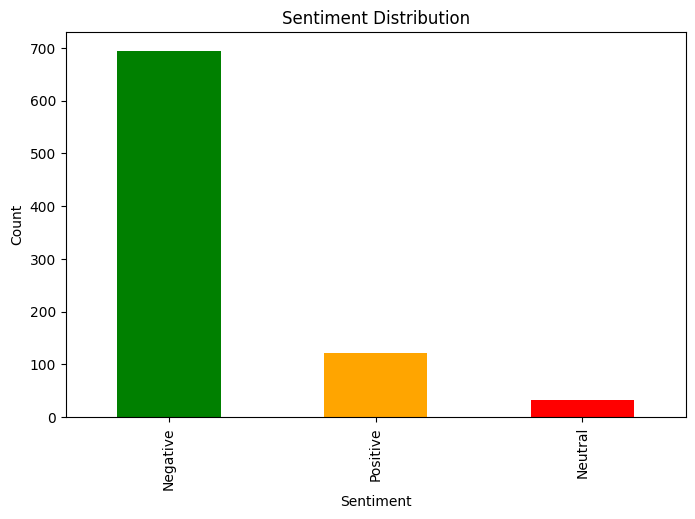

In [12]:
# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


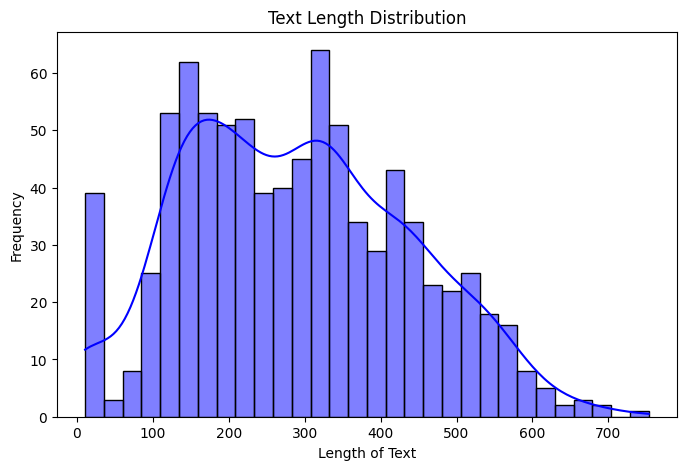

In [13]:
# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title("Text Length Distribution")
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Calculate descriptive statistics for text length
print(df['text_length'].describe())

count    850.000000
mean     288.950588
std      149.090758
min       11.000000
25%      171.250000
50%      283.500000
75%      399.000000
max      753.000000
Name: text_length, dtype: float64


In [15]:
# Step 3: Train-test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [16]:
# Step 1: Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(df_train['text']).toarray()

# Convert y_train to numeric labels
y_train = df_train['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2})

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Check the shape of resampled data
print(f"Original X_train shape: {X_train_tfidf.shape}")
print(f"Resampled X_train shape: {X_resampled.shape}")
print(f"Resampled y_train distribution: {Counter(y_resampled)}")

Original X_train shape: (680, 5000)
Resampled X_train shape: (1698, 5000)
Resampled y_train distribution: Counter({2: 566, 1: 566, 0: 566})


<ipython-input-16-04e9f1b6e02e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df_train['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2})


In [17]:
# Step 5: Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_len = 256

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [18]:
def tokenize_text(text, tokenizer, max_len):
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return encoded['input_ids'].squeeze(0), encoded['attention_mask'].squeeze(0)


df_train['tokenized_text'] = df_train['text'].apply(lambda x: tokenize_text(x, tokenizer, max_len))
df_val['tokenized_text'] = df_val['text'].apply(lambda x: tokenize_text(x, tokenizer, max_len))
df_test['tokenized_text'] = df_test['text'].apply(lambda x: tokenize_text(x, tokenizer, max_len))

# Split tokenized data into input_ids and attention_mask
X_train = torch.stack([x[0] for x in df_train['tokenized_text']])
attention_mask_train = torch.stack([x[1] for x in df_train['tokenized_text']])
y_train = torch.tensor(df_train['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2}).tolist())

# Repeat for validation and test sets
X_val = torch.stack([x[0] for x in df_val['tokenized_text']])
attention_mask_val = torch.stack([x[1] for x in df_val['tokenized_text']])
y_val = torch.tensor(df_val['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2}).tolist())

X_test = torch.stack([x[0] for x in df_test['tokenized_text']])
attention_mask_test = torch.stack([x[1] for x in df_test['tokenized_text']])
y_test = torch.tensor(df_test['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2}).tolist())

<ipython-input-18-f91e41b03e3d>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = torch.tensor(df_train['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2}).tolist())
<ipython-input-18-f91e41b03e3d>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = torch.tensor(df_val['label'].replace({"Positive": 0, "Negative": 1, "Neutral": 2}).tolist())
<ipython-input-18-f91e41b03e3d>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior

In [19]:
# Create TensorDatasets with attention_mask
train_dataset = TensorDataset(X_train, attention_mask_train, y_train)
val_dataset = TensorDataset(X_val, attention_mask_val, y_val)
test_dataset = TensorDataset(X_test, attention_mask_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
# Step 7: Model setup
num_labels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [21]:
# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [22]:
def train(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids, attention_mask, labels = batch  # Unpack three values
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        total_accuracy += (preds == labels).float().mean().item()

    scheduler.step()  # Update learning rate
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, labels = batch  # Unpack three values
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            total_accuracy += (preds == labels).float().mean().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy

In [23]:
# Training loop
epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, scheduler, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.25it/s]


Epoch 1/5:
  Train Loss: 0.6395, Train Accuracy: 0.7994
  Val Loss: 0.3849, Val Accuracy: 0.8125


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.24it/s]


Epoch 2/5:
  Train Loss: 0.3904, Train Accuracy: 0.8852
  Val Loss: 0.1848, Val Accuracy: 0.9375


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.21it/s]


Epoch 3/5:
  Train Loss: 0.2951, Train Accuracy: 0.9230
  Val Loss: 0.1441, Val Accuracy: 0.9583


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.22it/s]


Epoch 4/5:
  Train Loss: 0.2676, Train Accuracy: 0.9244
  Val Loss: 0.1413, Val Accuracy: 0.9479


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 10.20it/s]

Epoch 5/5:
  Train Loss: 0.2630, Train Accuracy: 0.9259
  Val Loss: 0.1398, Val Accuracy: 0.9479


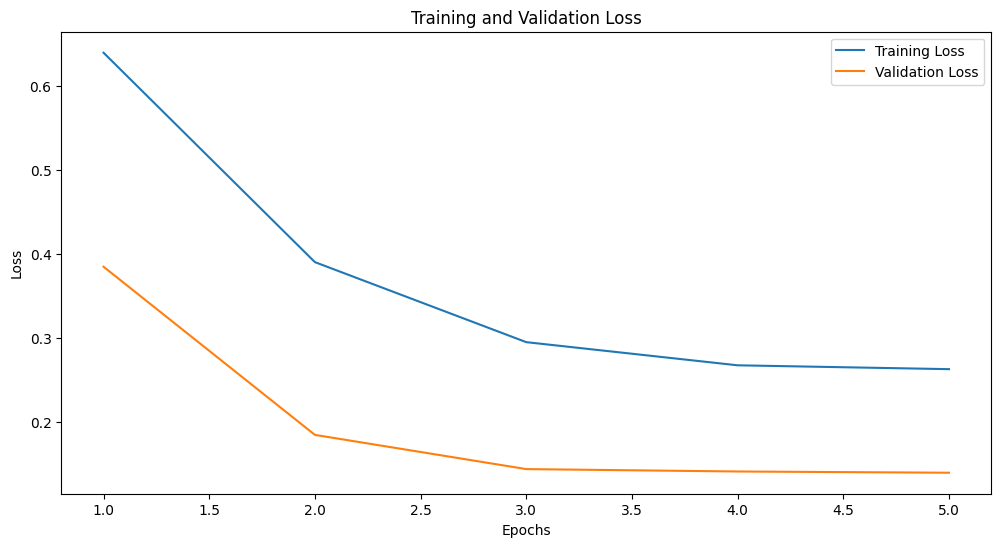

In [24]:
# Plot training and validation results
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

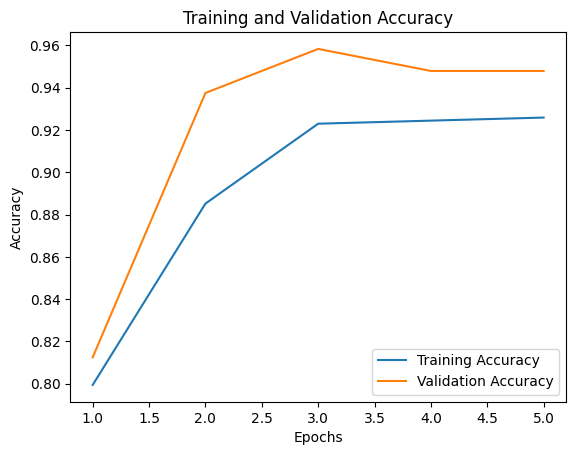

In [25]:
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [26]:
# Final evaluation on test set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids, attention_mask, labels = batch  # Unpack three values
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Positive", "Negative", "Neutral"]))

Testing: 100%|██████████| 6/6 [00:00<00:00, 10.22it/s]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.86      0.63      0.73        19
    Negative       0.85      0.97      0.90        62
     Neutral       0.00      0.00      0.00         4

    accuracy                           0.85        85
   macro avg       0.57      0.53      0.54        85
weighted avg       0.81      0.85      0.82        85




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


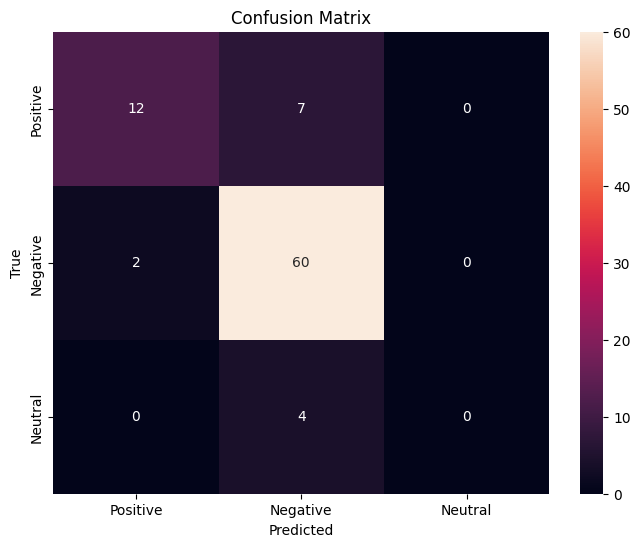

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Positive", "Negative", "Neutral"], yticklabels=["Positive", "Negative", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

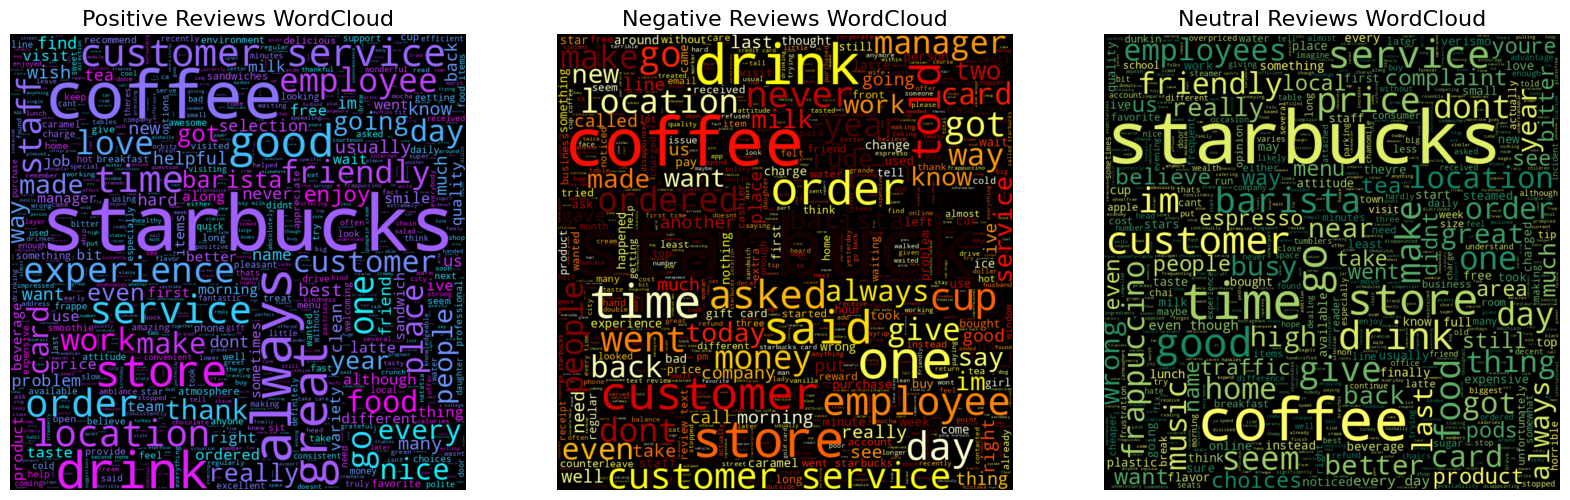

In [28]:
from wordcloud import WordCloud, STOPWORDS

# Generate WordCloud for Positive Reviews
positive_reviews = df[df["label"] == "Positive"]["text"]
positive_text = " ".join(positive_reviews)
positive_wordcloud = WordCloud(
    width=800, height=800, stopwords=STOPWORDS, background_color='black', max_words=800, colormap="cool"
).generate(positive_text)

# Generate WordCloud for Negative Reviews
negative_reviews = df[df["label"] == "Negative"]["text"]
negative_text = " ".join(negative_reviews)
negative_wordcloud = WordCloud(
    width=800, height=800, stopwords=STOPWORDS, background_color='black', max_words=800, colormap="hot"
).generate(negative_text)

# Generate WordCloud for Neutral Reviews
neutral_reviews = df[df["label"] == "Neutral"]["text"]
neutral_text = " ".join(neutral_reviews)
neutral_wordcloud = WordCloud(
    width=800, height=800, stopwords=STOPWORDS, background_color='black', max_words=800, colormap="summer"
).generate(neutral_text)

# Plot WordClouds
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title("Positive Reviews WordCloud", fontsize=16)
axes[0].axis("off")

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title("Negative Reviews WordCloud", fontsize=16)
axes[1].axis("off")

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title("Neutral Reviews WordCloud", fontsize=16)
axes[2].axis("off")

plt.show()

In [29]:
# Tokenize words from each sentiment category
positive_words = " ".join(df[df["label"] == "Positive"]["text"].dropna()).split()
negative_words = " ".join(df[df["label"] == "Negative"]["text"].dropna()).split()
neutral_words = " ".join(df[df["label"] == "Neutral"]["text"].dropna()).split()

# Count most common words in each sentiment category
positive_common_words = Counter(positive_words).most_common(20)
negative_common_words = Counter(negative_words).most_common(20)
neutral_common_words = Counter(neutral_words).most_common(20)

# Convert to DataFrame for visualization
df_positive_words = pd.DataFrame(positive_common_words, columns=['Word', 'Count'])
df_negative_words = pd.DataFrame(negative_common_words, columns=['Word', 'Count'])
df_neutral_words = pd.DataFrame(neutral_common_words, columns=['Word', 'Count'])

In [30]:
df_positive_words

,Word,Count
0,starbucks,127
1,coffee,85
2,always,60
3,service,55
4,great,47
5,store,37
6,good,36
7,customer,35
8,get,35
9,like,35


In [31]:
df_negative_words

,Word,Count
0,starbucks,891
1,coffee,487
2,one,252
3,customer,240
4,drink,239
5,get,230
6,said,211
7,store,211
8,time,203
9,service,194


In [32]:
df_neutral_words

,Word,Count
0,starbucks,42
1,coffee,22
2,time,15
3,get,13
4,go,12
5,good,11
6,like,11
7,store,11
8,day,9
9,service,8


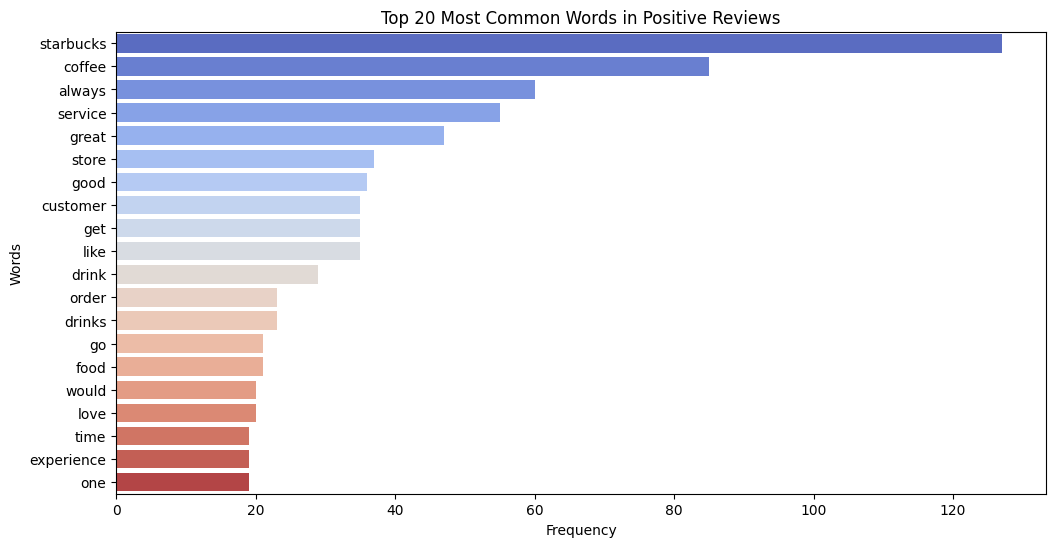

In [33]:
# Plot Most Common Words in Positive Reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_positive_words, palette="coolwarm")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Positive Reviews")
plt.show()

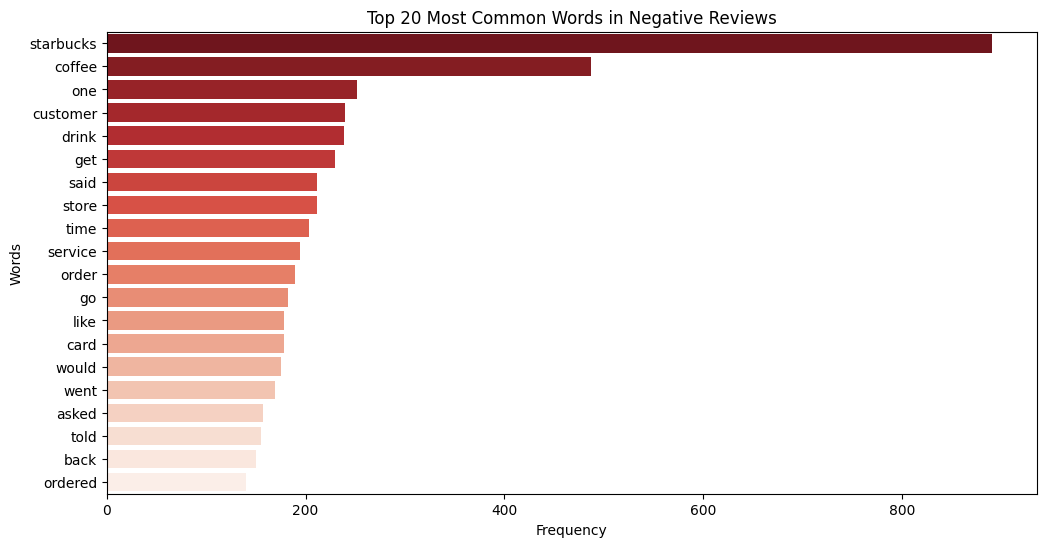

In [34]:
# Plot Most Common Words in Negative Reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_negative_words, palette="Reds_r")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Negative Reviews")
plt.show()

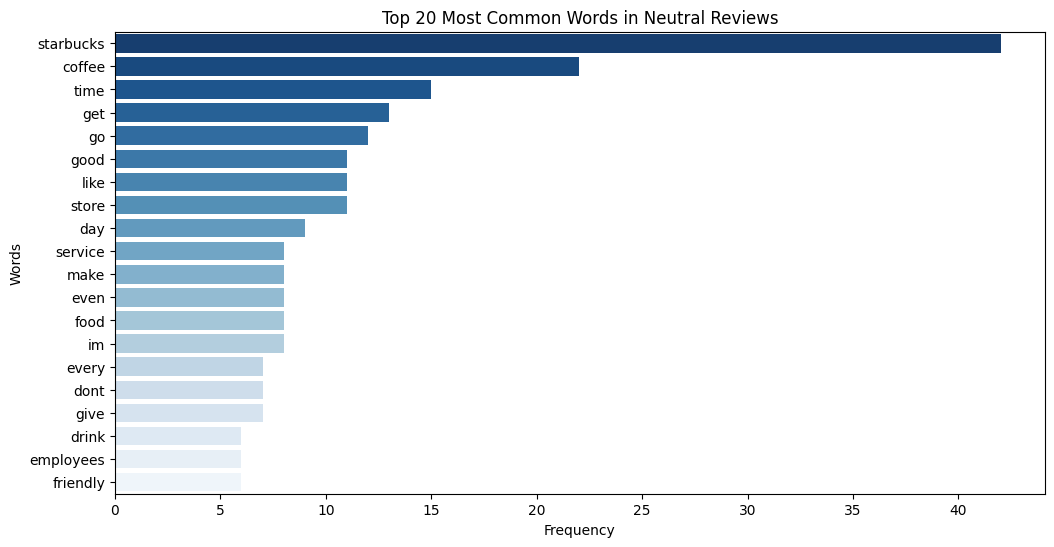

In [35]:
# Plot Most Common Words in Neutral Reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_neutral_words, palette="Blues_r")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Neutral Reviews")
plt.show()

In [36]:
import pandas as pd

# Step 1: Load dataset
df = pd.read_csv("/kaggle/input/starbucks-reviews-dataset/reviews_data.csv") 
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [37]:
# Step 2: Data Cleaning and Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    cleaned_text = ' '.join([word for word in tokens if word not in stop_words])
    return cleaned_text

# Fill missing values and clean text
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['text'] = df['Review'].apply(clean_text)
df.isnull().sum()

name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
text           0
dtype: int64

In [38]:
# Map sentiment labels
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'

df['label'] = df['Rating'].apply(map_sentiment)

# Grouping sentiment distribution by country
sentiment_by_country = df.groupby(['location', 'label']).size().unstack(fill_value=0)
sentiment_by_country

label,Negative,Neutral,Positive
location,,,
"93720, ca",1,0,0
"Abbotsford, BC",1,0,0
"Aberdeen, Other",0,0,1
"Abilene, TX",1,0,0
"Absecon, NJ",1,0,0
...,...,...,...
"Yonkers, NY",1,0,0
"Yorba Linda, CA",2,0,0
"Yorktown, VA",1,0,0


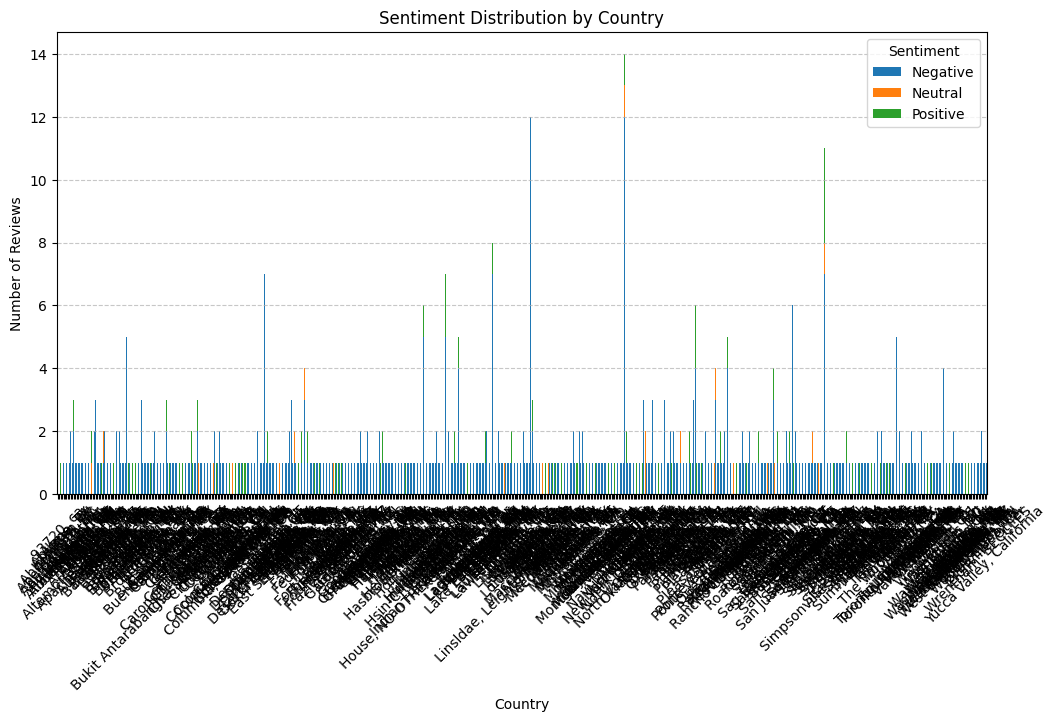

In [39]:
import matplotlib.pyplot as plt

# Plotting sentiment distribution by country
sentiment_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

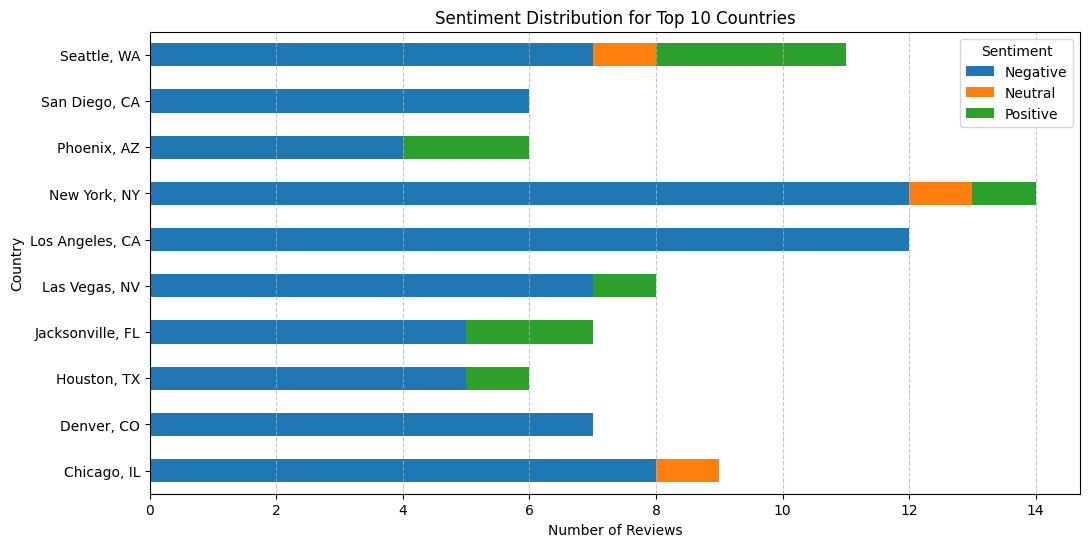

In [40]:
# Filtering top 10 locations with the most reviews
top_locations = df['location'].value_counts().nlargest(10).index
filtered_df = df[df['location'].isin(top_locations)]

# Grouping sentiment distribution for top locations
sentiment_top_locations = filtered_df.groupby(['location', 'label']).size().unstack(fill_value=0)

# Plotting improved sentiment distribution with a horizontal bar chart
sentiment_top_locations.plot(kind='barh', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for Top 10 Countries')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.legend(title='Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

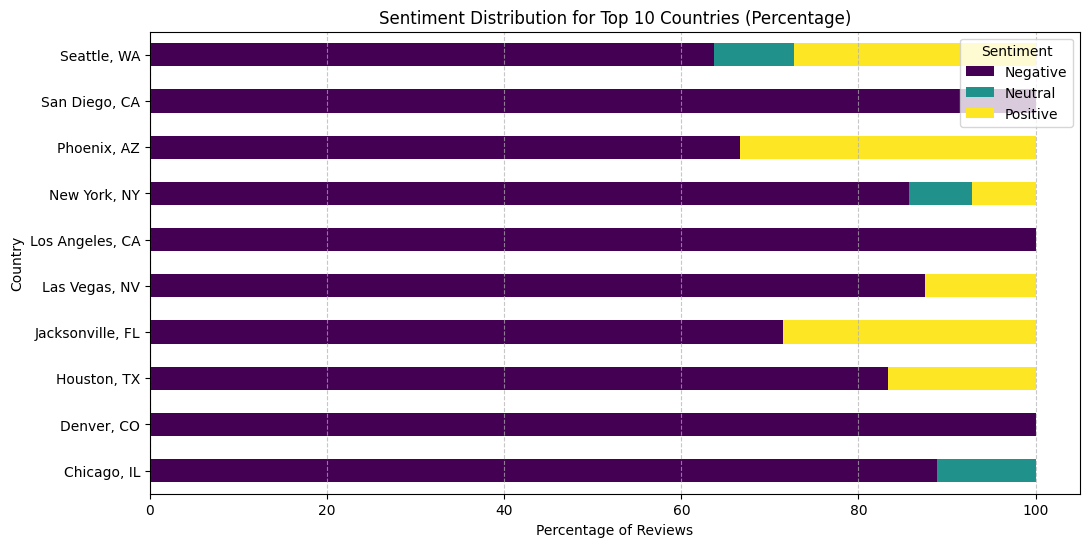

In [41]:
# Normalizing sentiment counts to percentages per country
sentiment_percentage = sentiment_top_locations.div(sentiment_top_locations.sum(axis=1), axis=0) * 100

# Plotting sentiment distribution as percentage (stacked bar chart)
sentiment_percentage.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Sentiment Distribution for Top 10 Countries (Percentage)')
plt.xlabel('Percentage of Reviews')
plt.ylabel('Country')
plt.legend(title='Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

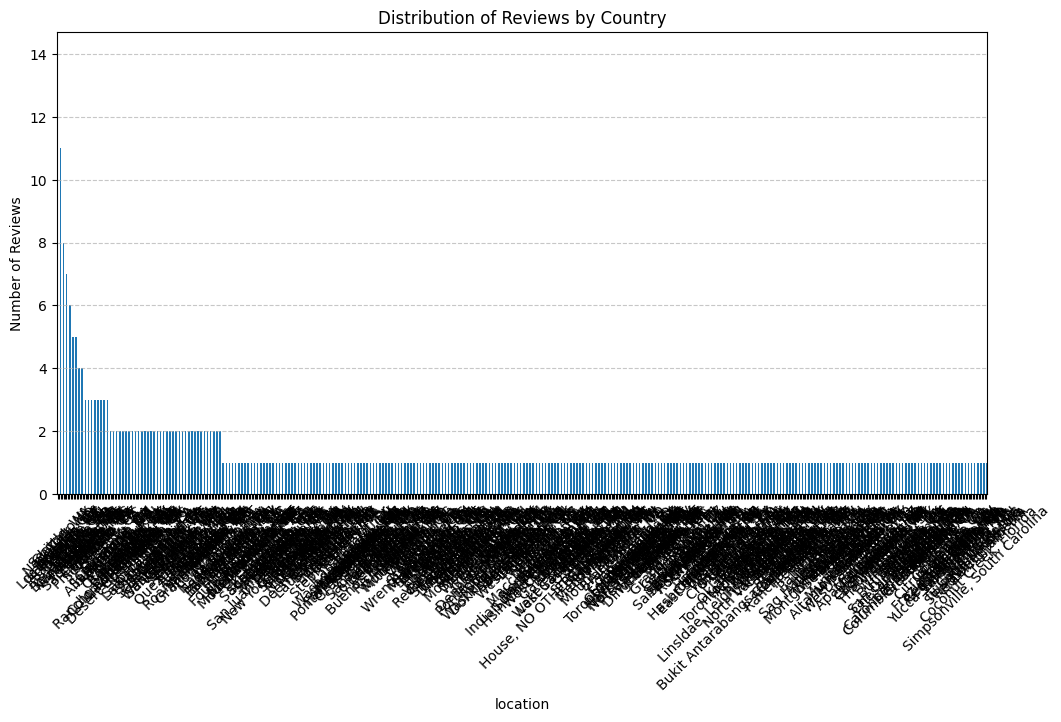

In [42]:
# Aggregating the number of reviews per country
location_counts = df['location'].value_counts()

# Plotting the distribution of reviews by location
plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar')
plt.title('Distribution of Reviews by Country')
plt.xlabel('location')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       850 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
 6   text         850 non-null    object 
 7   label        850 non-null    object 
dtypes: float64(1), object(7)
memory usage: 53.2+ KB


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Max 1000 words to avoid noise
X = vectorizer.fit_transform(df["text"])

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 20
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
lda.fit(X)

def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        print(f"🔹 Topic {topic_idx + 1}: {', '.join(words)}")

# Show topics
display_topics(lda, vectorizer.get_feature_names_out())

🔹 Topic 1: like, asked, said, store, customers, coffee, manager, service, customer, starbucks
🔹 Topic 2: stores, card, going, credit, used, morning, times, like, coffee, starbucks
🔹 Topic 3: order, drive, online, ordered, got, line, caramel, time, coffee, starbucks
🔹 Topic 4: time, product, great, quality, store, food, good, starbucks, customer, service
🔹 Topic 5: went, hand, lid, store, time, ordered, drink, cup, starbucks, coffee
🔹 Topic 6: make, sandwich, coffee, going, customers, tea, order, store, drink, starbucks
🔹 Topic 7: place, went, day, drink, work, starbucks, open, didnt, text, review
🔹 Topic 8: make, want, went, employees, like, store, people, customers, starbucks, coffee
🔹 Topic 9: guys, said, time, longer, like, muffin, dont, buy, drink, starbucks
🔹 Topic 10: went, caramel, didnt, starbucks, ordered, told, order, coffee, asked, said
🔹 Topic 11: use, dont, card, employees, coffee, day, service, days, customer, starbucks
🔹 Topic 12: decaf, music, time, told, ordered, emplo

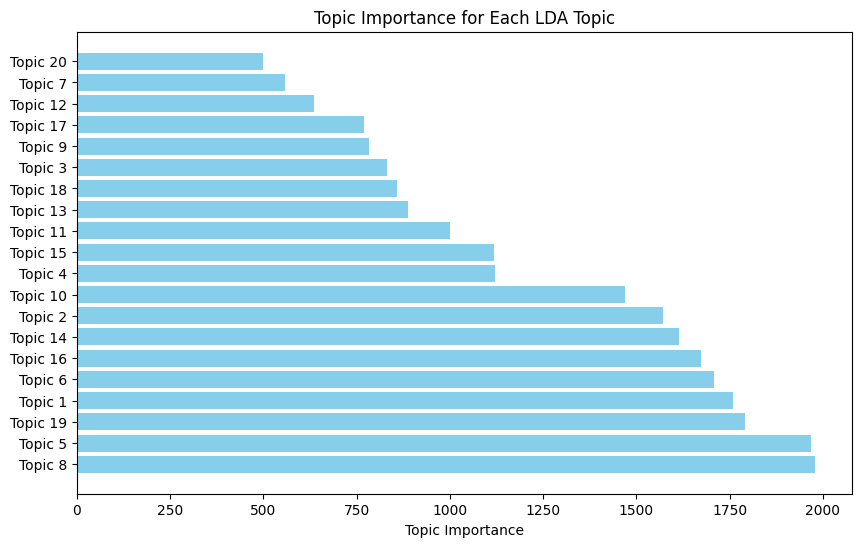

In [46]:
# Extracting topic distribution from LDA model
topic_distribution = lda.components_

# Summing the weights for each word in a topic (to represent the importance of each topic)
topic_importance = np.sum(topic_distribution, axis=1)

# Sorting topics by importance
sorted_topic_idx = np.argsort(topic_importance)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(n_topics), topic_importance[sorted_topic_idx], color='skyblue')
plt.yticks(range(n_topics), [f"Topic {i+1}" for i in sorted_topic_idx])
plt.xlabel("Topic Importance")
plt.title("Topic Importance for Each LDA Topic")
plt.gca().invert_yaxis()
plt.show()


LDA Analysis for Los Angeles, CA
🔹 Topic 1: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 2: starbucks, fees, district, customers, employees, area, service, manager, hollywood, customer
🔹 Topic 3: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 4: angeles, ca, little, bread, going, pm, coffee, time, like, starbucks
🔹 Topic 5: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 6: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 7: time, inside, starbucks, shift, thank, refills, today, policy, like, workers
🔹 Topic 8: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 9: like, dont, believe, usually, bad, apology, going, store, said, coffee
🔹 Topic 10: furthermore, fully, friends, freshly, food, crispy, rice, hair, square, inside
🔹 Topic 11: los, angeles, given, say, time, starbucks, buy, asked, chees

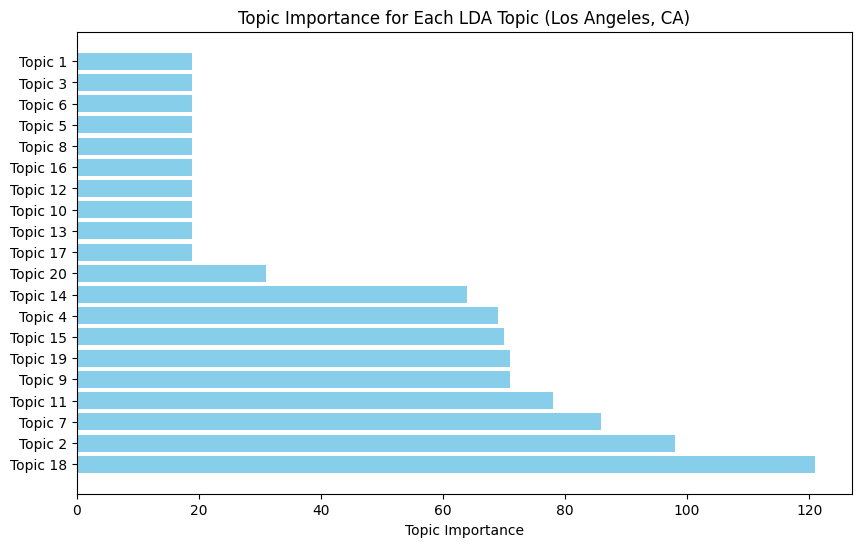

LDA Analysis for Seattle, WA
🔹 Topic 1: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 2: credit, union, business, told, paypal, manager, days, called, account, starbucks
🔹 Topic 3: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 4: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 5: start, work, cut, care, received, wa, services, noticed, tumblers, plastic
🔹 Topic 6: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 7: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 8: paper, venti, point, know, time, employees, sleeves, sleeve, extra, hot
🔹 Topic 9: smart, staying, day, look, starbucks, term, dont, company, service, customers
🔹 Topic 10: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 11: handled, half, groundhog, gross, gotten, got, good, gone, text, review
🔹 Topic 12: handled, half, groundhog, gross, 

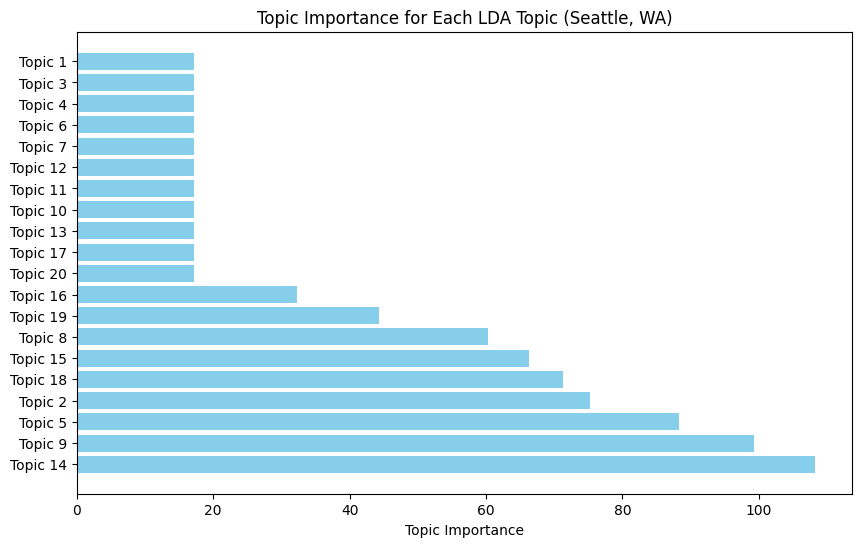

In [47]:
la_df = df[df['location'] == 'Los Angeles, CA']
seattle_df = df[df['location'] == 'Seattle, WA']

# Function to perform LDA and display topics for a given DataFrame
def perform_lda_analysis(df, n_topics=20):
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Max 1000 words to avoid noise
    X = vectorizer.fit_transform(df["text"])

    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
    lda.fit(X)

    # Function to display topics
    def display_topics(model, feature_names, num_words=10):
        for topic_idx, topic in enumerate(model.components_):
            words = [feature_names[i] for i in topic.argsort()[-num_words:]]
            print(f"🔹 Topic {topic_idx + 1}: {', '.join(words)}")

    # Display topics
    display_topics(lda, vectorizer.get_feature_names_out())

    # Extracting topic distribution from LDA model
    topic_distribution = lda.components_

    # Summing the weights for each word in a topic (to represent the importance of each topic)
    topic_importance = np.sum(topic_distribution, axis=1)

    # Sorting topics by importance
    sorted_topic_idx = np.argsort(topic_importance)

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(n_topics), topic_importance[sorted_topic_idx], color='skyblue')
    plt.yticks(range(n_topics), [f"Topic {i+1}" for i in sorted_topic_idx])
    plt.xlabel("Topic Importance")
    plt.title(f"Topic Importance for Each LDA Topic ({df['location'].iloc[0]})")
    plt.gca().invert_yaxis()
    plt.show()



# Perform LDA analysis for Los Angeles, CA
print("LDA Analysis for Los Angeles, CA")
perform_lda_analysis(la_df)
# Perform LDA analysis for Seattle, WA
print("LDA Analysis for Seattle, WA")
perform_lda_analysis(seattle_df)


In [48]:
# Strip the "Reviewed" part and convert the Date column
df['Date'] = df['Date'].str.replace('Reviewed ', '')  # Remove 'Reviewed'

month_map = {
    'Jan.': 'January',
    'Feb.': 'February',
    'Mar.': 'March',
    'Apr.': 'April',
    'May': 'May',
    'Jun.': 'June',
    'Jul.': 'July',
    'Aug.': 'August',
    'Sept.': 'September',
    'Oct.': 'October',
    'Nov.': 'November',
    'Dec.': 'December'
}


for abbrev, full in month_map.items():
    df['Date'] = df['Date'].str.replace(abbrev, full)

# Now, remove any remaining periods and convert to datetime
df['Date'] = df['Date'].str.replace(r'\.$', '', regex=True)  # Remove any remaining period

# Convert to datetime with the expected format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%B %d, %Y')  # %B for full month name

# Drop rows where Date conversion failed
df = df.dropna(subset=['Date'])

# Extract Month (YYYY-MM) from the Date column
df['Month'] = df['Date'].dt.to_period('M')  # Extract Month (YYYY-MM)

# Check the results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         850 non-null    object        
 1   location     850 non-null    object        
 2   Date         850 non-null    datetime64[ns]
 3   Rating       850 non-null    float64       
 4   Review       850 non-null    object        
 5   Image_Links  850 non-null    object        
 6   text         850 non-null    object        
 7   label        850 non-null    object        
 8   Month        850 non-null    period[M]     
dtypes: datetime64[ns](1), float64(1), object(6), period[M](1)
memory usage: 59.9+ KB


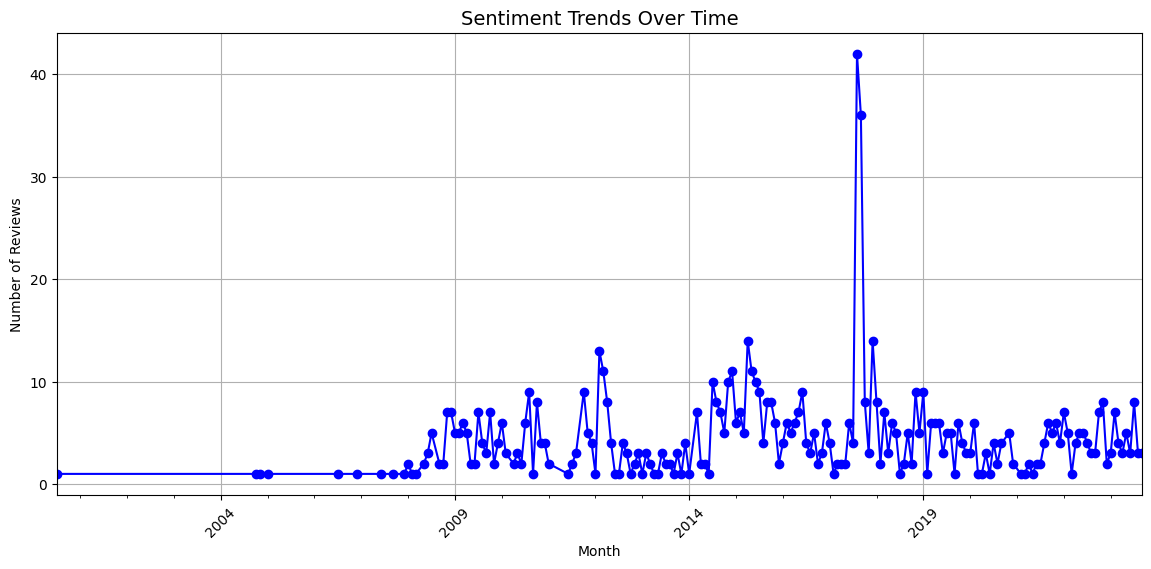

In [49]:
sentiment_trend = df.groupby('Month')['text'].count()

plt.figure(figsize=(14,6))
sentiment_trend.plot(kind='line', marker='o', color='blue')

plt.title("Sentiment Trends Over Time", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


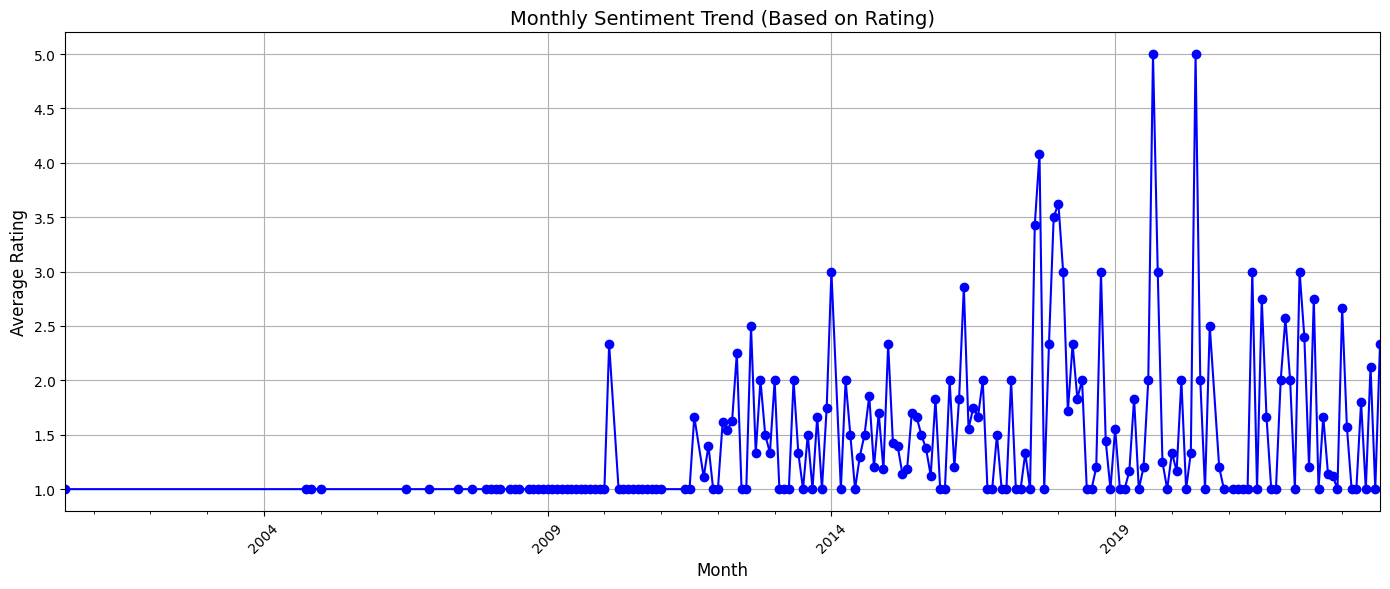

In [50]:
# Group by 'Month' and calculate the average rating for each month
monthly_rating_trend = df.groupby('Month')['Rating'].mean()

# Plot the trend
plt.figure(figsize=(14, 6))
monthly_rating_trend.plot(kind='line', marker='o', color='blue')

# Add title and labels
plt.title("Monthly Sentiment Trend (Based on Rating)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.tight_layout()
plt.show()